In [55]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [56]:
import numpy as np
import pandas as pd

In [57]:
import datetime as dt
import dateutil.parser as dp


# Reflect Tables into SQLAlchemy ORM

In [58]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [59]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [60]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [61]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [62]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [63]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [64]:
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x123457d68>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'id': 1,
 'tobs': 65.0,
 'date': '2010-01-01'}

In [65]:
st_first_row = session.query(Station).first()
st_first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1234319e8>,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397'}

In [66]:
dict(session.query(Station.station,Station.name).distinct().all())


{'USC00519397': 'WAIKIKI 717.2, HI US',
 'USC00513117': 'KANEOHE 838.1, HI US',
 'USC00514830': 'KUALOA RANCH HEADQUARTERS 886.9, HI US',
 'USC00517948': 'PEARL CITY, HI US',
 'USC00518838': 'UPPER WAHIAWA 874.3, HI US',
 'USC00519523': 'WAIMANALO EXPERIMENTAL FARM, HI US',
 'USC00519281': 'WAIHEE 837.5, HI US',
 'USC00511918': 'HONOLULU OBSERVATORY 702.2, HI US',
 'USC00516128': 'MANOA LYON ARBO 785.2, HI US'}

In [67]:
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
one_year_ago = dp.parse(*last_date) - dt.timedelta(days = 365)

In [69]:
one_year_prcp = pd.read_sql(session.query(Measurement.date,Measurement.prcp).\
filter(func.Date(Measurement.date) >= one_year_ago).statement,session.bind)
one_year_prcp.set_index('date',inplace= True)
one_year_prcp.head()

,prcp
date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01


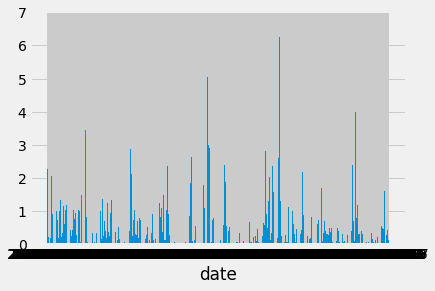

In [70]:
plt.bar(x = one_year_prcp.index,height = one_year_prcp.prcp,label = 'precipitation')
plt.xlabel('date')
plt.show()

In [40]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data


![precipitation](Images/precipitation.png)

In [71]:
# Use Pandas to calcualte the summary statistics for the precipitation data

one_year_prcp.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [72]:
# Design a query to show how many stations are available in this dataset?
session.query(Measurement.station).distinct().count()


9

In [73]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [74]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
filter(Measurement.station == 'USC00519281').first()

(54.0, 85.0, 71.66378066378067)

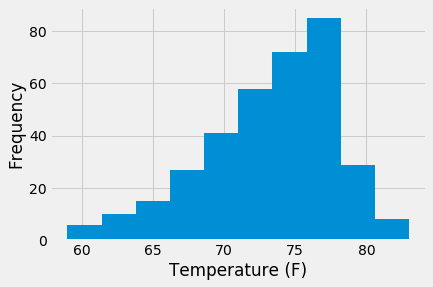

In [75]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
one_year_temp = pd.read_sql(session.query(Measurement.tobs).\
filter(func.DATE(Measurement.date)>= one_year_ago).\
filter(Measurement.station == 'USC00519281').statement,session.bind)
plt.hist(one_year_temp['tobs'])
plt.ylabel('Frequency')
plt.xlabel('Temperature (F)')
plt.show()

![precipitation](Images/station-histogram.png)

In [76]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))
print(calc_temps('2012-02-28', '2012-03-05')[0][0])

[(62.0, 69.57142857142857, 74.0)]
62.0


### Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
### for your trip using the previous year's data for those same dates.


In [77]:
start_date = '2017-01-01'
end_date = '2017-01-15'
last_year_temp = calc_temps(start_date,end_date)[0]
print(last_year_temp)

(60.0, 68.5505617977528, 81.0)


Text(0.5,1,'Trip Avg Temp')

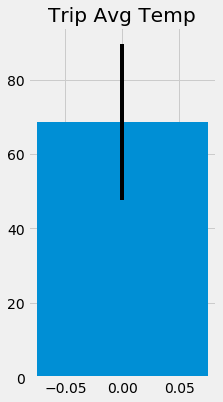

In [78]:
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots()
fig.set_size_inches(3,6)
ax.bar(np.arange(1),last_year_temp[1],width = 0.15,yerr = last_year_temp[2]-last_year_temp[0])
ax.set_title('Trip Avg Temp')

<IPython.core.display.Javascript object>


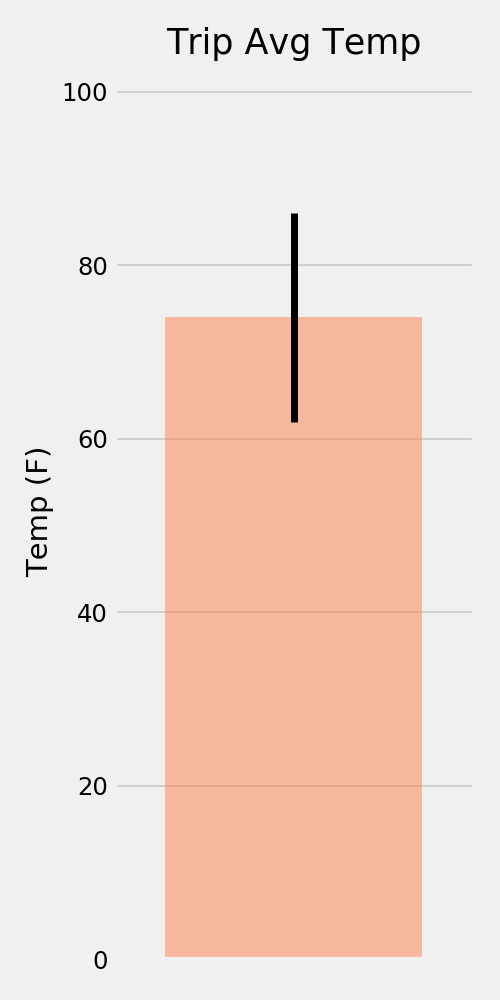

In [18]:
# Plot the results from your previous query as a bar chart. 


In [79]:
session.query(Measurement.station,Station.name,
              func.sum(Measurement.prcp),Station.latitude,Station.longitude,Station.elevation).\
filter(Measurement.station == Station.station).\
filter(Measurement.date >=start_date).filter(Measurement.date <= end_date).\
group_by(Measurement.station,Station.name,Station.latitude,Station.longitude,Station.elevation).\
order_by(func.sum(Measurement.prcp).desc()).all()

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  0.64,
  21.3331,
  -157.8025,
  152.4),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  0.63,
  21.5213,
  -157.8374,
  7.0),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  0.61,
  21.33556,
  -157.71139,
  19.5),
 ('USC00513117', 'KANEOHE 838.1, HI US', 0.35, 21.4234, -157.8015, 14.6),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  0.21000000000000002,
  21.45167,
  -157.84888999999998,
  32.9),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 0.0, 21.2716, -157.8168, 3.0),
 ('USC00517948', 'PEARL CITY, HI US', None, 21.3934, -157.9751, 11.9)]

In [80]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [81]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [104]:
# calculate the daily normals for your trips
normals = []
num_days = (dp.parse(end_date) -  dp.parse(start_date)).days +1
# push each tuple of calculations into a list called `normals`
for i in range(0,num_days):
    theday = dp.parse(start_date)+dt.timedelta(days = i)
    normals.append(*daily_normals(theday.strftime('%m-%d')))
# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date
normals

[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0),
 (57.0, 67.16071428571429, 75.0),
 (58.0, 67.9298245614035, 78.0),
 (62.0, 69.74137931034483, 77.0),
 (57.0, 67.3103448275862, 78.0),
 (57.0, 67.4074074074074, 81.0),
 (57.0, 67.25454545454545, 77.0),
 (58.0, 69.52631578947368, 77.0),
 (56.0, 69.31372549019608, 78.0)]

In [110]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_normals = pd.DataFrame(normals,columns=["Min Temp","Avg Temp","Max Temp"],
             index=[(dp.parse(start_date)+dt.timedelta(days = i)) for i in range(0,num_days)])
trip_normals

,Min Temp,Avg Temp,Max Temp
2017-01-01,62.0,69.153846,77.0
2017-01-02,60.0,69.396226,77.0
2017-01-03,62.0,68.909091,77.0
2017-01-04,58.0,70.000000,76.0
2017-01-05,56.0,67.964286,76.0
2017-01-06,61.0,68.964912,76.0
2017-01-07,57.0,68.543860,76.0
2017-01-08,57.0,67.160714,75.0
2017-01-09,58.0,67.929825,78.0
2017-01-10,62.0,69.741379,77.0


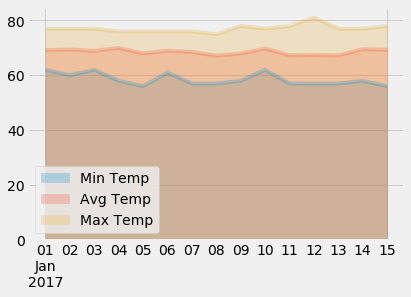

In [122]:
trip_normals.plot(kind = 'area',stacked = False,alpha = 0.25)

<IPython.core.display.Javascript object>


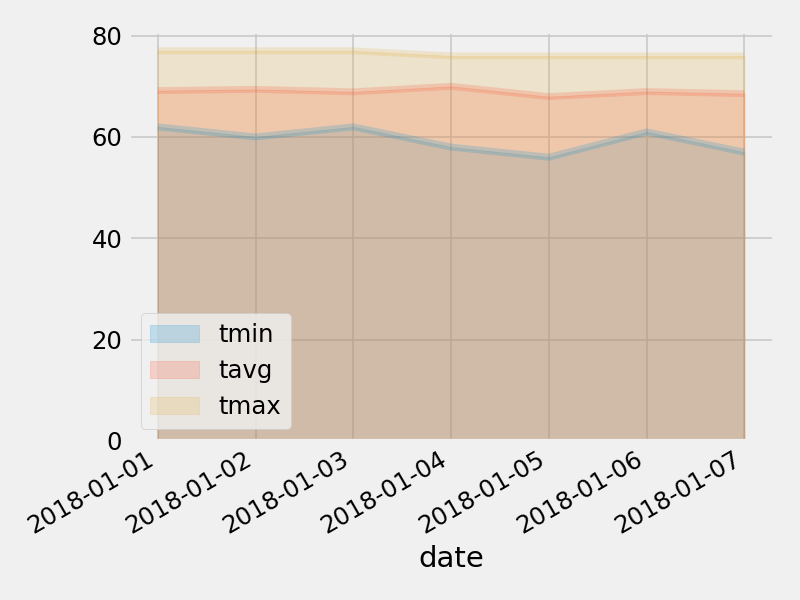

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
